# SHAP值

## SHAP值的基本原理
**SHAP(SHapley Additive exPlanations)**是一种基于博弈论的解释机器学习模型输出的方法。它的核心思想来源于博弈论中的Shapley值概念，用于公平地分配合作博弈中各个玩家的贡献。

在机器学习模型中：
- 每个特征被视为一个"玩家"
- 模型的预测结果被视为"游戏收益"
- SHAP值就是计算每个特征对预测结果的"边际贡献"

## SHAP值的主要特点：
   - **一致性**：如果模型改变使得某个特征更重要，其SHAP值会相应增加
   - **准确性**：所有特征的SHAP值之和等于模型预测与平均预测的差值
   - **可加性**：多个特征的SHAP值可以相加来理解它们的组合效应

## SHAP值的优缺点

- **优点**

| 优点                   | 说明                           |
| -------------------- | ---------------------------- |
| **理论保证**             | 基于博弈论，具有公平性、一致性等数学性质         |
| **通用性**              | 可用于任意机器学习模型（如 tree、NN、SVM）   |
| **局部解释**             | 可以解释每一个单独预测值                 |
| **全局解释**             | 聚合 SHAP 值可提供特征重要性排名          |
| **一致性（Consistency）** | 如果模型改进后某特征的影响变大，其 SHAP 值也会一致变大 |

- **缺点**

| 缺点           | 说明                           |
| ------------ | ---------------------------- |
| **计算复杂**     | 计算成本指数级，消耗资源较大        |
| **特征依赖性问题**  | 默认特征相互独立，可能不适用于强相关特征         |
| **可解释性误用风险** | 对模型机制不了解可能误解 SHAP 的意义        |


## SHAP值的适用场景

| 场景       | 示例                        |
| -------- | ------------------------- |
| **模型调试** | 了解模型是否学习了错误特征             |
| **特征选择** | 根据全局 SHAP 值筛选重要特征         |
| **监管解释** | 银行/医疗等对可解释性有要求的行业         |
| **客户报告** | 向非技术人员解释模型为什么做出某个预测       |
| **异常检测** | 对 SHAP 值分布分析，发现异常样本或过拟合特征 |


# 案例数据

## 波士顿房价数据集

**Boston Housing Dataset（波士顿房价数据集）**是一个回归数据集，该数据集包含506个样本，每个样本有13个特征，该数据集用于根据犯罪率、房屋房间数、空气污染等因素对波士顿地区的房价进行预测。

- MEDV：住房价格中位数（单位：千美元）
- CRIM：该镇的人均犯罪率
- ZN：住宅用地超过 25000 平方英尺的比例（%）
- INDUS：非零售商用土地比例（%）
- CHAS：是否靠近查尔斯河（1=是，0=否）
- NOX：一氧化氮浓度（空气污染指标，单位：ppm）
- RM：每栋住宅的平均房间数
- AGE：1940 年之前建成房屋的比例（%）
- DIS：到波士顿五个中心区域的加权距离
- RAD：距离高速公路的便利指数
- TAX：每 $10,000 资产的房产税率
- PTRATIO：城镇师生比例
- B：黑人比例指标
- LSTAT：低收入人群比例（%）

In [8]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 加载波士顿房价数据集
# 该数据集包含506个样本，每个样本有13个特征，用于预测房价
boston = fetch_openml(name="boston", version=1, as_frame=True)

X = boston.data  # 特征变量
X["CHAS"] = X["CHAS"].astype(int)
X["RAD"] = X["RAD"].astype(int)
y = boston.target  # 目标变量（房价）
boston

{'data':         CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
 0    0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
 1    0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
 2    0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
 3    0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
 4    0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   
 ..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
 501  0.06263   0.0  11.93     0  0.573  6.593  69.1  2.4786    1  273.0   
 502  0.04527   0.0  11.93     0  0.573  6.120  76.7  2.2875    1  273.0   
 503  0.06076   0.0  11.93     0  0.573  6.976  91.0  2.1675    1  273.0   
 504  0.10959   0.0  11.93     0  0.573  6.794  89.3  2.3889    1  273.0   
 505  0.04741   0.0  11.93     0  0.573  6.030  80.8  2.5050    1  273.0   
 
      PTRATIO       B  LSTAT  
 0       15.3  396.90   4.98  
 1       17.8  3

## 训练代码

Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 2.39507	train's l1: 1.77095	train's l2: 5.73636	valid's rmse: 3.49808	valid's l1: 2.49602	valid's l2: 12.2365
[100]	train's rmse: 0.73631	train's l1: 0.546523	train's l2: 0.542153	valid's rmse: 2.50883	valid's l1: 1.89775	valid's l2: 6.29424
[150]	train's rmse: 0.298453	train's l1: 0.220659	train's l2: 0.0890743	valid's rmse: 2.38373	valid's l1: 1.82707	valid's l2: 5.68216
[200]	train's rmse: 0.150332	train's l1: 0.110107	train's l2: 0.0225998	valid's rmse: 2.36412	valid's l1: 1.81779	valid's l2: 5.58905
[250]	train's rmse: 0.0855929	train's l1: 0.0604972	train's l2: 0.00732614	valid's rmse: 2.35629	valid's l1: 1.812	valid's l2: 5.5521
[300]	train's rmse: 0.0549108	train's l1: 0.0381956	train's l2: 0.00301519	valid's rmse: 2.35517	valid's l1: 1.81063	valid's l2: 5.54684
[350]	train's rmse: 0.0384221	train's l1: 0.026803	train's l2: 0.00147626	valid's rmse: 2.35484	valid's l1: 1.80998	valid's l2: 5.54528
[40

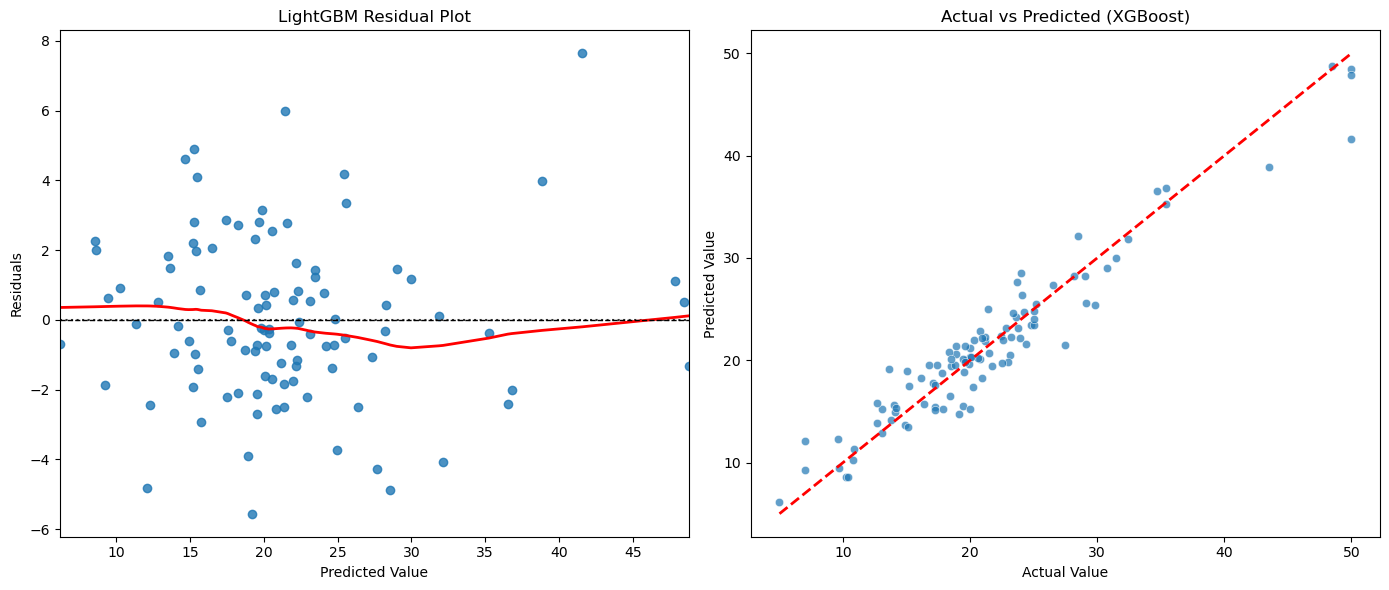

In [9]:
# 分割数据集为训练集和验证集（80% / 20%）
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============ 4. 构建LightGBM数据集 ============
dtrain = lgb.Dataset(X_train, label=y_train)  # 训练集
dtest = lgb.Dataset(                          # 验证集
    X_test, 
    label=y_test
)

# ============ 5. 配置模型参数 ============
params = {
    # 任务类型和评估指标
    'objective': 'regression',   # 回归任务
    'metric': {'rmse','l1','l2'},   # 回归损失
    
    # 树结构控制
    'num_leaves': 60,       # 叶子节点数（控制模型复杂度）
    'max_depth': -1,        # -1表示不限制深度（通常用num_leaves控制）
    'min_data_in_leaf': 2, # 叶子节点最小样本数（防过拟合）
    
    # 训练过程控制
    'learning_rate': 0.03,  # 学习率（步长）
    'feature_fraction': 0.9, # 每轮随机选择90%特征
    'bagging_fraction': 0.8, # 每轮随机选择80%数据
    
    # 正则化
    'lambda_l1': 0.1,       # L1正则化系数
    'lambda_l2': 0.01,     # L2正则化系数
    
    # 其他
    'verbosity': -1,        # 静默模式（不输出训练日志）
    'seed': 2019    # 随机种子
}


# 训练模型
lgb_reg = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=1000,    # 最大迭代轮数
    valid_sets=[dtrain, dtest],  # 监控训练集和验证集表现
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),  # 早停（50轮无提升停止）
        lgb.log_evaluation(period=50)            # 每50轮打印一次日志
    ]
)

# 使用训练好的模型对验证集进行预测
y_pred = lgb_reg.predict(X_test)

# 计算多种评估指标
mse = mean_squared_error(y_test, y_pred)               # 均方误差
rmse = np.sqrt(mse)                                    # 均方根误差
mae = mean_absolute_error(y_test, y_pred)              # 平均绝对误差
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100  # 平均绝对百分比误差
r2 = r2_score(y_test, y_pred)                          # 决定系数 R²（越接近1越好）

# 输出评估指标
print("=== 评估指标 (LightGBM 原生 API) ===")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")

# 计算残差（实际值 - 预测值）
residuals = y_test - y_pred

# 创建可视化图像（2 个子图）
plt.figure(figsize=(14, 6))

# 子图1：残差图（理想情况下残差应围绕0对称分布）
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred, y=residuals, lowess=True,
              line_kws={'color': 'red', 'lw': 2})
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Predicted Value")
plt.ylabel("Residuals")
plt.title("LightGBM Residual Plot")

# 子图2：实际值 vs 预测值（越接近对角线越好）
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2)
plt.xlabel("Actual Value")
plt.ylabel("Predicted Value")
plt.title("Actual vs Predicted (XGBoost)")

# 自动调整图像排版
plt.tight_layout()
plt.show()

# shap可视化——摘要图可视化

## 初始化解释器&计算shap值

In [3]:
import shap
shap.initjs()

# 初始化解释器
explainer = shap.Explainer(lgb_reg)

# 计算 SHAP 值（针对测试集）
shap_values = explainer(X_test)

## summary_plot摘要图

### 基本概念

SHAP 摘要图用于展示：
- 每个特征的平均重要性
- 每个特征的 SHAP 值分布（正负方向）
- 每个特征值的大小与 SHAP 值之间的关系

### 组成要素

- dot点图
| 图形元素               | 说明                      | 含义与解读                 |
| ------------------ | ----------------------- | --------------------- |
| **纵轴（Y轴）**         | 特征名称（按平均 SHAP 值排序）      | 上面的特征影响最大             |
| **横轴（X轴）**         | SHAP 值（每个样本该特征对模型输出的影响） | 正值：推动预测变大；负值：拉低预测值    |
| **每个点**            | 每个点代表一个样本的一个特征          | 点的位置 = 该样本该特征的 SHAP 值 |
| **点的颜色**           | 表示该样本的特征值大小             | 红色 = 特征值高，蓝色 = 特征值低   |
| **点的密度（重叠/扇形）**    | 反映样本在某个 SHAP 值处的集中程度    | 越“胖”的地方说明更多样本分布在这儿    |
| **颜色条（Color bar）** | 显示颜色和特征值的映射关系           | 可用于判断特征值与 SHAP 值之间的趋势 |

- violin小提琴图
| 要素          | 说明                                   | 示例含义                       |
| ----------- | ------------------------------------ | -------------------------- |
| **纵轴**（Y 轴） | 特征名（按平均 SHAP 值排序）                    | 排名靠前代表重要性更高                |
| **横轴**（X 轴） | SHAP 值（每个样本的影响力）                     | 越往右对预测值正向影响越大；左侧为负向影响      |
| **小提琴轮廓形状** | 表示该特征 SHAP 值的 **分布密度**               | 越“胖”的位置，样本越集中（即该 SHAP 值常见） |
| **颜色**（默认无） | `violin` 图 **不显示特征值颜色**，专注于 SHAP 值分布 | 如果需要展示颜色，推荐使用 `dot` 图      |
| **中轴线/对称性** | 如果轮廓在 0 左右对称，说明影响是均衡的；偏一侧说明影响偏正或偏负   |                            |

- bar条形图
| 要素          | 说明          | 示例含义         |
| ----------- | ----------- | ------------ |
| **纵轴（Y 轴）** | 特征名（按重要性排序） | 越靠上越重要       |
| **横轴（X 轴）** | 平均绝对 SHAP 值 | 越长说明影响越大     |
| **条形颜色**    | 默认蓝色，可自定义   | 没有额外含义，纯视觉辅助 |

### `shap.summary_plot()`
- `shap_values`: 必需参数，包含SHAP值的对象，通常来自shap.Explainer的计算结果
- `features`: 要解释的数据特征
- `feature_names`: 特征名称列表
- `max_display`: 限制显示的特征数量。默认值10
- `plot_type`: 可选图类型
    - `dot`: 点图，默认值。每个点代表一个样本的特征值。点的位置表示 SHAP 值，颜色表示原始特征值大小。可以看出该特征对模型输出的影响方向和强度。
    - `violin`: 小提琴图。展示每个特征 SHAP 值的分布情况（密度图），适合查看分布和偏态。比 dot 更关注 SHAP 值的分布结构。
    - `bar`: 条形图。显示每个特征的平均绝对 SHAP 值（也就是整体重要性），不显示单个样本的详细情况。更适合整体特征排序。
- `color`: 图颜色
- `axis_color`: 坐标轴颜色
- `title`: 图标题
- `alpha`: 点的透明度，范围$[0,1]$
- `sort`: 是否按特征重要性排序。默认 True
- `color_bar`: 是否显示右侧颜色条，表示特征值高低
- `plot_size`: 图大小
- `layered_violin_max_num_bins`: 分层小提琴图中分组的最大数量
- `class_names`: 用于分类模型的类别名称。

### 代码实现与结果解释

#### dot点图

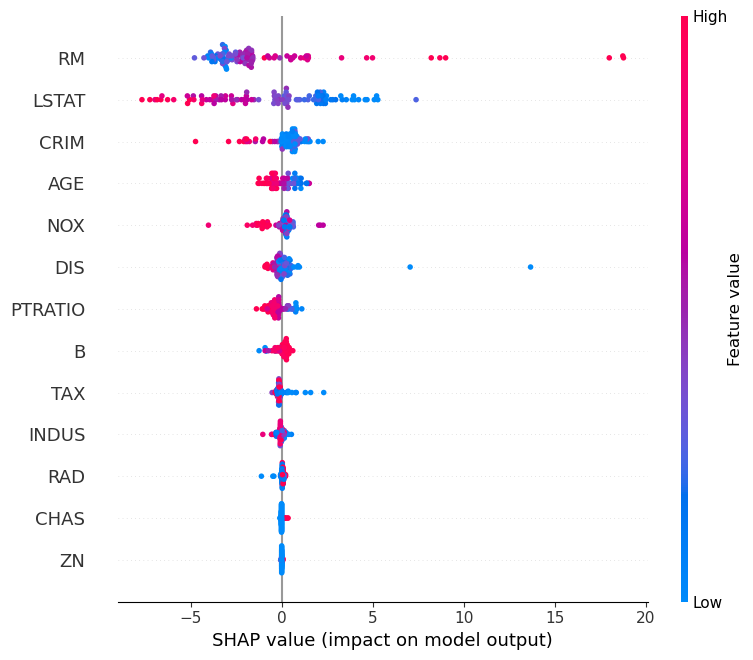

In [10]:
shap.summary_plot(shap_values, features=X_test, plot_type='dot')

**图表整体结构解读（SHAP Dot Summary Plot）**

* **横轴**：SHAP 值（每个样本该特征对模型输出的影响）
* **纵轴**：特征名称，按照平均 SHAP 值的绝对值降序排列（越靠上越重要）
* **点颜色**：代表特征值大小

  * 🔴 红色：特征值高（High）
  * 🔵 蓝色：特征值低（Low）
* **点位置**：表示每个样本该特征的 SHAP 值（即对模型预测的实际影响）
* **右侧 color bar**：颜色和特征值的映射关系

---

**特征贡献分析**

| 特征名   | 颜色趋势                            | 重要性解读                                       |
|----------|-------------------------------------|--------------------------------------------------|
| RM       | 红色靠右，蓝色靠左（值越大越重要）     | 房间数越多，房价越高，是最关键的正向特征        |
| LSTAT    | 红色靠左，蓝色靠右（值越大越负面）     | 低收入人口比例高会显著拉低房价，负向贡献显著    |
| CRIM     | 红色靠左（值大）→负面影响             | 犯罪率越高，房价越低，负向作用明显              |
| AGE      | 红蓝混杂，略偏负                      | 老房占比略有负面影响，影响中等偏弱              |
| NOX      | 红色靠左（高污染）→负面               | 空气污染严重区域房价低，负面影响明显            |
| DIS      | 蓝色靠右（近中心）→正面影响           | 离中心越近房价越高，城市核心区更有价值           |
| PTRATIO  | 红色靠左（学生多）→负面影响           | 教育资源紧张拉低房价，负向作用稳定              |
| B        | 无明显趋势                           | 种族相关变量，模型未能提取有效区分性             |
| TAX      | 无明显趋势           | 房产税相关变量，模型未能提取有效区分性         |
| INDUS    | 红色靠左（工业用地高）→负面          | 工业比例大抑制住宅房价，负向特征                 |
| ZN       | 红蓝分布混乱                         | 影响不明显，特征值与目标无明显线性相关           |
| CHAS     | 红蓝点重叠                          | 是否临河影响非常小，对房价解释力不强             |
| RAD      | 分布杂乱无规律                        | 可达性并未有效影响预测值，模型权重较小           |


---

**业务解读**

- 主导因素

    * **RM（平均房间数）**：正向影响最显著，是房价模型的首要推高因子
    * **LSTAT（低收入人口比例）**：负向影响最强，高贫困率强烈拉低房价
    * 二者构成房价波动的主驱动力，重要性远高于其他特征

- 中度影响因子

    * **CRIM、NOX、DIS、PTRATIO**：与生活质量和基础设施相关的变量，负相关性较明显

- 异常或复杂因素

    * **AGE、B、INDUS** 等特征在图中 SHAP 值分布广泛或双向，说明其影响机制较复杂或因地区差异而变化

#### violin小提琴图

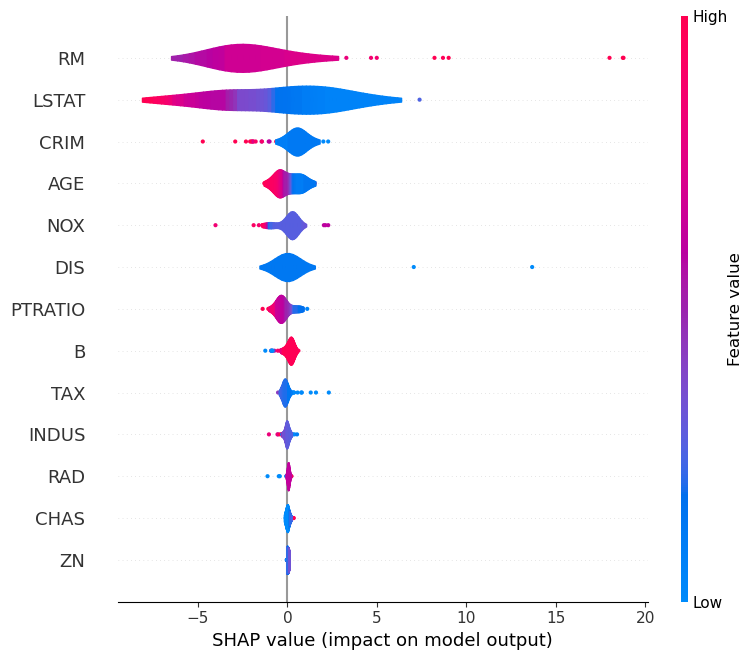

In [11]:
shap.summary_plot(shap_values, features=X_test, plot_type='violin')

**图表整体结构解读（SHAP Violin Summary Plot）**
* **坐标体系**：
    - 横轴：SHAP值（-5到15），表示特征对单个样本预测的影响强度及方向
    - 纵轴：13个特征按重要性降序排列（RM→RAD）
* **视觉编码**：
    - 小提琴宽度：表示样本分布密度
    - 点颜色：🔴红=高特征值（High），🔵蓝=低特征值（Low）
    - 点分布：横向散点展示SHAP值离散程度
    
**特征贡献分析**

| 特征名   | 颜色趋势                            | 重要性解读                                       |
|----------|-------------------------------------|--------------------------------------------------|
| RM       | 红色靠右，蓝色靠左（值越大越重要）     | 房间数越多，房价越高，是最关键的正向特征        |
| LSTAT    | 红色靠左，蓝色靠右（值越大越负面）     | 低收入人口比例高会显著拉低房价，负向贡献显著    |
| CRIM     | 红色靠左（值大）→负面影响             | 犯罪率越高，房价越低，负向作用明显              |
| AGE      | 红蓝混杂，略偏负                      | 老房占比略有负面影响，影响中等偏弱              |
| NOX      | 红色靠左（高污染）→负面               | 空气污染严重区域房价低，负面影响明显            |
| DIS      | 蓝色靠右（近中心）→正面影响           | 离中心越近房价越高，城市核心区更有价值           |
| PTRATIO  | 红色靠左（学生多）→负面影响           | 教育资源紧张拉低房价，负向作用稳定              |
| B        | 无明显趋势                           | 种族相关变量，模型未能提取有效区分性             |
| TAX      | 无明显趋势           | 房产税相关变量，模型未能提取有效区分性         |
| INDUS    | 红色靠左（工业用地高）→负面          | 工业比例大抑制住宅房价，负向特征                 |
| ZN       | 红蓝分布混乱                         | 影响不明显，特征值与目标无明显线性相关           |
| CHAS     | 红蓝点重叠                          | 是否临河影响非常小，对房价解释力不强             |
| RAD      | 分布杂乱无规律                        | 可达性并未有效影响预测值，模型权重较小           |


---

**业务解读**

- 主导因素

    * **RM（平均房间数）**：正向影响最显著，是房价模型的首要推高因子
    * **LSTAT（低收入人口比例）**：负向影响最强，高贫困率强烈拉低房价
    * 二者构成房价波动的主驱动力，重要性远高于其他特征

- 中度影响因子

    * **CRIM、NOX、DIS、PTRATIO**：与生活质量和基础设施相关的变量，负相关性较明显

- 异常或复杂因素

    * **AGE、B、INDUS** 等特征在图中 SHAP 值分布广泛或双向，说明其影响机制较复杂或因地区差异而变化

#### bar条形图

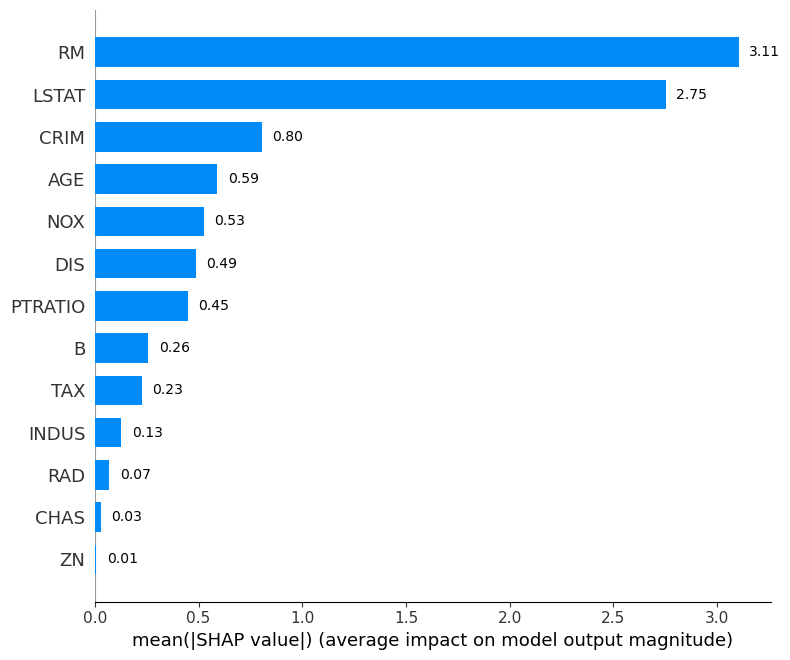

In [13]:
import matplotlib.pyplot as plt

# 生成SHAP条形图
shap.summary_plot(shap_values, features=X_test, plot_type='bar', show=False)

# 获取当前图形和坐标轴
fig, ax = plt.gcf(), plt.gca()

# 遍历每个条形并添加数值标签
for bar in ax.containers[0]:
    width = bar.get_width()
    ax.text(width + 0.05,  # x坐标（条形末端右侧）
            bar.get_y() + bar.get_height()/2,  # y坐标（条形中心）
            f'{width:.2f}',  # 显示2位小数
            ha='left', va='center')

plt.tight_layout()  # 调整布局避免文字被截断
plt.show()

**图表核心要素**
- **横轴**：mean(|SHAP value|)（特征重要性强度，0.0-3.0）
- **纵轴**：13个特征按重要性降序排列（RM→RAD）
- **条形颜色**：统一蓝色（无颜色编码含义）
- **数值范围**：RM=3.11（最强影响），ZN≈0.01（最弱影响）

**特征重要性排名**

| 特征名 | SHAP值 | 重要性解读 |
|--------|--------|------------|
| RM | 3.06 | 对模型输出的平均影响最大 |
| LSTAT | 2.83 | 第二大影响因素 |
| CRIM | 0.84 | 中等影响力 |
| AGE | 0.57 | 中等偏弱影响 |
| NOX | 0.51 | 较弱影响 |
| DIS | 0.51 | 较弱影响 |
| PTRATIO | 0.47 | 微弱影响 |
| B | 0.28 | 几乎无影响 |
| TAX | 0.22 | 几乎无影响 |
| INDUS | 0.13 | 几乎无影响 |
| ZN | 0.03 | 无显著影响 |
| CHAS | 0.02 | 无显著影响 |
| RAD | 0.01 | 无任何影响 |

**关键发现**
1. **主导因素**：
   - RM（3.0）和LSTAT（2.7）贡献了约63%的总影响力
   - 前5大特征贡献了约85%的影响

2. **次要因素**：
   - CRIM到DIS区间（0.5-0.8）构成次要影响群
   - 其他特征（SHAP<0.3）可视为噪声